In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# FASTER R CNN - Bus/Truck Object Detection

## kaggle data download

In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader

import torchvision.transforms as transforms

from torchvision.utils import make_grid
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import nms

import utils
import os
import pandas as pd
import numpy as np
import random
import shutil
import cv2
import json
import matplotlib.pyplot as plt
from time import time

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from ipywidgets import interact
from collections import defaultdict

import warnings
warnings.filterwarnings(action='ignore')

In [4]:
!pip install kaggle --upgrade

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"seonyong","key":"15cdbf608ae7dcc43e31d8ac3e790795"}'}

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning이 발생하지 않도록 해줍니다.
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!mkdir data/
%cd data

/content/data


In [8]:
!kaggle datasets download -d sixhky/open-images-bus-trucks

100% 367M/367M [00:20<00:00, 18.4MB/s]
100% 367M/367M [00:20<00:00, 18.3MB/s]


In [9]:
!unzip -qq '/content/data/open-images-bus-trucks.zip'

## data 전처리

In [10]:
data_dir  = '/content/data/images'

In [11]:
# 데이터 전체 수
data_len = os.listdir(data_dir + '/images')
len(data_len)

15225

In [12]:
df = pd.read_csv('/content/data/df.csv')
df = df.loc[:, ['ImageID', 'LabelName', 'XMin', 'XMax', 'YMin', 'YMax']]
df.head()

,ImageID,LabelName,XMin,XMax,YMin,YMax
0,0000599864fd15b3,Bus,0.343750,0.908750,0.156162,0.650047
1,00006bdb1eb5cd74,Truck,0.276667,0.697500,0.141604,0.437343
2,00006bdb1eb5cd74,Truck,0.702500,0.999167,0.204261,0.409774
3,00010bf498b64bab,Bus,0.156250,0.371250,0.269188,0.705228
4,00013f14dd4e168f,Bus,0.287500,0.999375,0.194184,0.999062


- 데이터셋 나누기

In [13]:
# 데이터셋 비율 - 8:1:1
split_ratio = [0.8, 0.1, 0.1]
train_len = int(len(data_len) * split_ratio[0])
val_len = int(len(data_len) * split_ratio[1])
test_len = len(data_len) - train_len - val_len
print('{}, {}, {}'.format(train_len, val_len, test_len))

12180, 1522, 1523


In [14]:
# 데이터를 랜덤으로 섞고 길이에 따라서 데이터 나누기
data_list = (os.listdir(data_dir+'/images'))
random.shuffle(data_list)

train_img, val_img, test_img = [], [], []

for i in range(len(data_list)):
    if 0 <= i < train_len:
        train_img.append(data_list[i])
    elif train_len <= i < train_len + val_len:
        val_img.append(data_list[i])
    elif train_len + val_len <= i:
        test_img.append(data_list[i])

print('{}, {}, {}'.format(len(train_img), len(val_img), len(test_img)))

12180, 1522, 1523


In [15]:
!mkdir 'train' 'val' 'test'

In [16]:
# 8:1:1 비율로 각각의 폴더 안에 데이터 나누어 넣기
to_file_path = '/content/data/'
from_file_path = '/content/data/images/images/'

for idx, file_name in enumerate(os.listdir(from_file_path)):
    if 0 <= idx < train_len:
        shutil.copyfile(from_file_path + file_name, to_file_path + 'train/' + file_name)
    elif train_len <= idx < train_len + val_len:
        shutil.copyfile(from_file_path + file_name, to_file_path + 'val/' + file_name)
    elif train_len +  val_len <= idx:
        shutil.copyfile(from_file_path + file_name, to_file_path + 'test/' + file_name)

print('{}, {}, {}'.format(len(os.listdir(to_file_path+'train')), len(os.listdir(to_file_path+'val')), len(os.listdir(to_file_path+'test'))))

12180, 1522, 1523


In [17]:
print('{}, {}, {}'.format(len(os.listdir(to_file_path+'train')), len(os.listdir(to_file_path+'val')), len(os.listdir(to_file_path+'test'))))

12180, 1522, 1523


- data 들여다보기

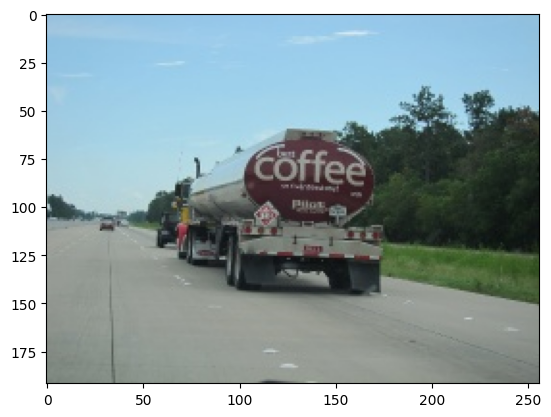

In [18]:
data_dir = '/content/data'

index = 205
file_name = os.listdir(data_dir + '/train')[index]
image = cv2.imread(os.path.join(data_dir, 'train', file_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [19]:
image_id = file_name.split('.')[0]
image_id

'003701c6de4ab948'

In [20]:
# 바운딩 box는 하나가 아닐 수도 있다
meta_data = df[df['ImageID'] == image_id]
meta_data

,ImageID,LabelName,XMin,XMax,YMin,YMax
85,003701c6de4ab948,Truck,0.140625,0.163750,0.533333,0.574167
86,003701c6de4ab948,Truck,0.255625,0.685625,0.310833,0.763333


In [21]:
label = meta_data['LabelName'].values
label

array(['Truck', 'Truck'], dtype=object)

In [22]:
# Normalize -> 원본 크기로 변환해야 할 필요가 있다.
boxes = meta_data[['XMin', 'XMax', 'YMin', 'YMax']].values
print(boxes, type(boxes[0]))

[[0.140625 0.16375  0.533333 0.574167]
 [0.255625 0.685625 0.310833 0.763333]] <class 'numpy.ndarray'>


In [23]:
CLASS_NAME_TO_ID = {'Bus':0, 'Truck':1}
CLASS_NAME_TO_ID

{'Bus': 0, 'Truck': 1}

In [24]:
CLASS_ID_TO_NAME = {0: 'Bus', 1: 'Truck'}
CLASS_ID_TO_NAME

{0: 'Bus', 1: 'Truck'}

In [25]:
class_ids = [CLASS_NAME_TO_ID[id] for id in label]
class_ids

[1, 1]

In [26]:
img_H, img_W, _ = image.shape

unnorm_bboxes = boxes.copy()
unnorm_bboxes[:, [1,2]] = unnorm_bboxes[:, [2,1]]
unnorm_bboxes[:, 2:4] -= unnorm_bboxes[:, 0:2]
unnorm_bboxes[:, 0:2] += (unnorm_bboxes[:, 2:4] / 2)
unnorm_bboxes[:, [0,2]] *= img_W
unnorm_bboxes[:, [1,3]] *= img_H

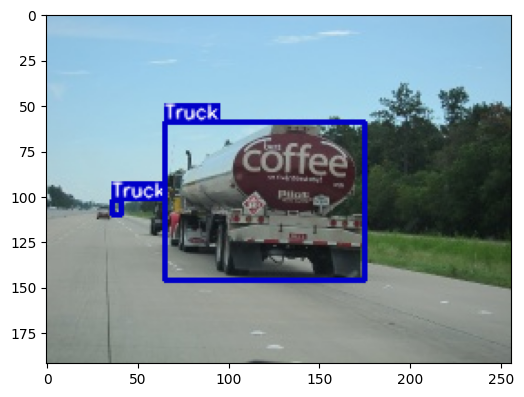

In [27]:
canvas = utils.visualize(image, unnorm_bboxes, class_ids)
plt.figure(figsize=(6,6))
plt.imshow(canvas)
plt.show()

In [28]:
image_files = os.listdir(data_dir + '/train')

In [29]:
@interact(index=(0, len(image_files)-1))
def show_sample(index=0):
    image_file = image_files[index]
    image_path = os.path.join('/content/data/train', image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image_id = image_file.split('.')[0]
    meta_data = df[df['ImageID'] == image_id]
    cate_names = meta_data["LabelName"].values
    bboxes = meta_data[["XMin", "XMax", "YMin", "YMax"]].values

    img_H, img_W, _ = image.shape

    class_ids = [CLASS_NAME_TO_ID[cate_name] for cate_name in cate_names]
    unnorm_bboxes = bboxes.copy()
    unnorm_bboxes[:, [1,2]] = unnorm_bboxes[:, [2,1]]
    unnorm_bboxes[:, 2:4] -= unnorm_bboxes[:, 0:2]
    unnorm_bboxes[:, 0:2] += (unnorm_bboxes[:, 2:4] / 2)
    unnorm_bboxes[:, [0,2]] *= img_W
    unnorm_bboxes[:, [1,3]] *= img_H
    canvas = utils.visualize(image, unnorm_bboxes, class_ids)

    plt.figure(figsize=(6,6))
    plt.imshow(canvas)
    plt.axis('off')
    plt.show()
    print(canvas.shape)

interactive(children=(IntSlider(value=0, description='index', max=12179), Output()), _dom_classes=('widget-int…

- dataset 만들기

In [30]:
class MyDataset():
    def __init__(self, data_dir, phase, transform=None):
        super().__init__()

        self.data_dir = data_dir
        self.phase = phase
        self.df = pd.read_csv(os.path.join(self.data_dir, 'df.csv'))
        self.image_files = [file_name for file_name in os.listdir(os.path.join(self.data_dir, phase)) if file_name.endswith('jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        file_name, image = self.get_image(index)
        boxes, class_ids = self.get_label(file_name)
        img_h, img_w, _ = image.shape

        if self.transform:
            image = self.transform(image)
            _, img_h, img_w = image.shape

        boxes[:, [0, 2]] *= img_w
        boxes[:, [1, 3]] *= img_h

        target = {}
        target['boxes'] = torch.Tensor(boxes).float()
        target['labels'] = torch.Tensor(class_ids).long()

        return image, target, file_name

    def get_image(self, index):
        file_name = self.image_files[index]
        image_path = os.path.join(self.data_dir, self.phase, file_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return file_name, image

    def get_label(self, file_name):
        image_id = file_name.split('.')[0]
        meta_data = self.df[self.df['ImageID'] == image_id]
        label_names = meta_data['LabelName'].values
        class_ids = np.array([CLASS_NAME_TO_ID[label_name] for label_name in label_names])
        boxes = meta_data[['XMin', 'XMax', 'YMin', 'YMax']].values
        boxes[:, [1, 2]] = boxes[:, [2, 1]] # -> xmin, ymin, xmax, ymax
        return boxes, class_ids

In [31]:
data_dir = '/content/data'
dataset = MyDataset(data_dir, 'train')
len(dataset)

12180

In [32]:
image, target, file_name = dataset[0]

In [33]:
image.shape, target, file_name

((192, 256, 3),
 {'boxes': tensor([[182.0800, 119.3601, 244.4800, 138.7200]]),
  'labels': tensor([1])},
 '39fac0e910b58065.jpg')

In [34]:
boxes = target['boxes'].numpy()
class_ids = target['labels'].numpy()

n_obj = boxes.shape[0]
bboxes = np.zeros(shape=(n_obj, 4), dtype=np.float32)
bboxes[:, 0:2] = (boxes[:, 0:2] + boxes[:, 2:4]) / 2
bboxes[:, 2:4] = (boxes[:, 2:4] - boxes[:, 0:2])

In [35]:
bboxes

array([[213.28    , 129.04004 ,  62.399994,  19.35994 ]], dtype=float32)

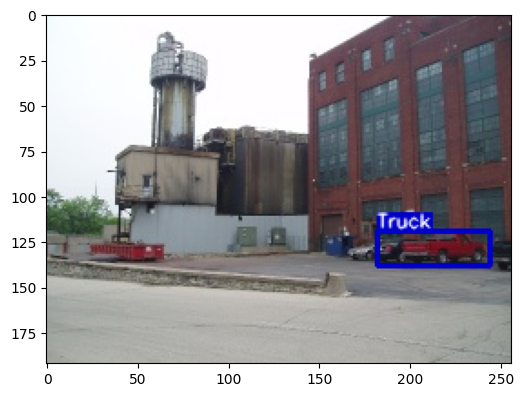

In [36]:
canvas = utils.visualize(image, bboxes, class_ids)
plt.figure(figsize=(6,6))
plt.imshow(canvas)
plt.show()

In [37]:
@interact(index=(0, len(dataset)-1))
def show_sample(index=0):
    image, target, file_name = dataset[index]
    boxes = target['boxes'].numpy()
    class_ids = target['labels'].numpy()

    n_obj = boxes.shape[0]
    bboxes = np.zeros(shape=(n_obj, 4), dtype=np.float32)
    bboxes[:, 0:2] = (boxes[:, 0:2] + boxes[:, 2:4]) / 2
    bboxes[:, 2:4] = (boxes[:, 2:4] - boxes[:, 0:2])
    canvas = utils.visualize(image, bboxes, class_ids)
    plt.figure(figsize=(6,6))
    plt.imshow(canvas)
    plt.show()

interactive(children=(IntSlider(value=0, description='index', max=12179), Output()), _dom_classes=('widget-int…

In [38]:
IMAGE_SIZE = 448

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
                                transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [39]:
data_dir = '/content/data/'
train_dataset = MyDataset(data_dir=data_dir, phase='train', transform=transform)
val_dataset = MyDataset(data_dir=data_dir, phase='val', transform=transform)

In [40]:
len(train_dataset), len(val_dataset)

(12180, 1522)

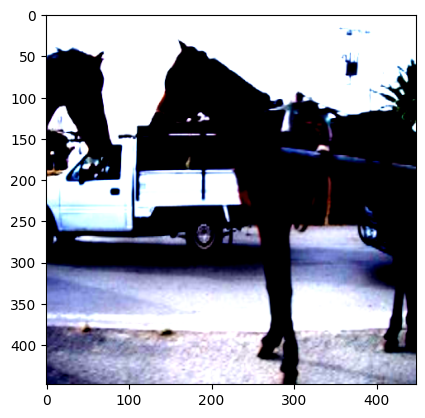

In [41]:
index = 50
image, target, file_name = train_dataset[index] #-> normalize
plt.imshow(image.permute(1, 2, 0).numpy())

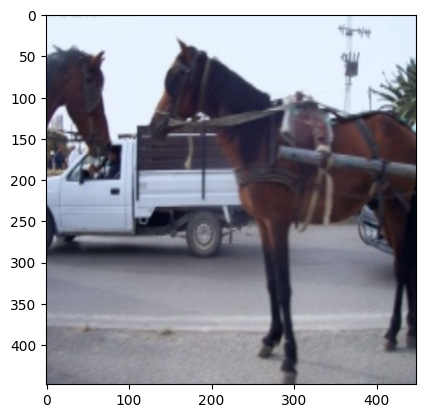

In [42]:
grid_image = make_grid(image, normalize=True).permute(1, 2, 0).numpy() # -> unnormalize
plt.imshow(grid_image)

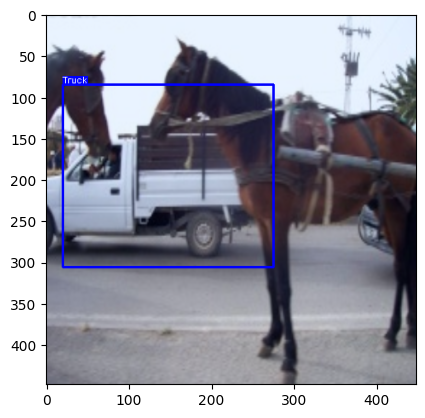

In [43]:
boxes = target['boxes'].numpy()
class_ids = target['labels'].numpy()
n_obj = boxes.shape[0]
bboxes = np.zeros(shape=(n_obj, 4), dtype=np.float32)
bboxes[:, 0:2] = (boxes[:, 0:2] + boxes[:, 2:4]) / 2
bboxes[:, 2:4] = boxes[:, 2:4] - boxes[:, 0:2]

canvas = utils.visualize(grid_image, bboxes, class_ids)
plt.imshow(canvas)
plt.show()

In [44]:
def collate_fn(batch):
    image_list = []
    filename_list = []
    target_list = []

    for a, b, c in batch: # image, target, file name
        image_list.append(a)
        target_list.append(b)
        filename_list.append(c)
    return image_list, target_list, filename_list

In [45]:
data_dir = '/content/data'
BATCH_SIZE = 6

trainset = MyDataset(data_dir=data_dir, phase='train', transform=transform)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

In [46]:
for index, batch in enumerate(trainloader):
    images = batch[0]
    targets = batch[1]
    filename = batch[2]

    break

In [47]:
len(images), images[0].shape

(6, torch.Size([3, 448, 448]))

In [48]:
targets

[{'boxes': tensor([[ 42.0000,  21.0130, 392.0000, 421.9439]]),
  'labels': tensor([1])},
 {'boxes': tensor([[ 93.1002, 136.2668, 313.9499, 294.0000]]),
  'labels': tensor([0])},
 {'boxes': tensor([[  0.0000, 167.1062, 123.2000, 310.9788],
          [304.6400, 140.2979, 447.5520, 367.2767]]),
  'labels': tensor([1, 1])},
 {'boxes': tensor([[128.9366, 383.0400, 299.0310, 424.7600],
          [ 49.1707, 393.9600, 147.8763, 425.3200]]),
  'labels': tensor([1, 1])},
 {'boxes': tensor([[ 66.6400, 148.4945, 370.1600, 426.1873]]),
  'labels': tensor([1])},
 {'boxes': tensor([[ 99.1200, 335.2532, 204.9600, 426.3468]]),
  'labels': tensor([1])}]

In [49]:
filename

['7084f970205193f8.jpg',
 'ab349f6d4f6e13aa.jpg',
 '007cdfad5b85d3e7.jpg',
 'ff78d4ac2e87d81a.jpg',
 '89315bf434722140.jpg',
 'd64185b6f1bce40e.jpg']

In [50]:
def build_dataloader(data_dir, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE):
    transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
                                transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])

    dataloaders = {}
    train_dataset = MyDataset(data_dir=data_dir, phase='train', transform=transform)
    val_dataset = MyDataset(data_dir=data_dir, phase='val', transform=transform)
    test_dataset = MyDataset(data_dir=data_dir, phase='test', transform=transform)

    dataloaders['train'] = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    dataloaders['val'] = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
    dataloaders['test'] = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

    return dataloaders

In [51]:
data_dir = '/content/data/'
BATCH_SIZE = 4
IMAGE_SIZE = 448

dataloaders = build_dataloader(data_dir=data_dir, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE)

In [52]:
for phase in ['train', 'val']:
    for index, batch in enumerate(dataloaders[phase]):
        images = batch[0]
        targets = batch[1]
        filename = batch[2]
        print(f'{phase} - {targets}')
        print(f'{phase} - {filename}')
        break

train - [{'boxes': tensor([[ 23.8000, 138.5068, 412.1600, 387.5200]]), 'labels': tensor([1])}, {'boxes': tensor([[388.9200, 219.5200, 441.0000, 281.1200],
        [112.5600, 174.3468, 367.3600, 314.7200],
        [ 40.3200, 243.4132, 141.4000, 310.9868],
        [115.3600, 176.2132, 371.2800, 313.6000],
        [370.1600, 222.5068, 405.4400, 274.0268]]), 'labels': tensor([1, 0, 1, 1, 1])}, {'boxes': tensor([[  0.8400, 153.8163, 313.6000, 433.7110]]), 'labels': tensor([1])}, {'boxes': tensor([[337.8910, 305.7600, 447.5798, 447.7200]]), 'labels': tensor([0])}]
train - ['fd7b83a1f87a8081.jpg', 'e3a0c16227ae4abd.jpg', '0ed8d53bd0c88fc8.jpg', '00c098c7959397c3.jpg']
val - [{'boxes': tensor([[ 88.4800, 168.2491, 331.5200, 368.3555]]), 'labels': tensor([1])}]
val - ['1b8fe37bf9479ab6.jpg']


## Faster R-CNN 아키텍쳐
- 아키텍쳐 불러오기
- class 수에 맞춰 2로 output을 2로 변경

In [53]:
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 83.0MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [54]:
in_features = model.roi_heads.box_predictor.cls_score.in_features

In [55]:
num_classes = 2
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [56]:
def build_model(num_classes):
    model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [57]:
NUM_CLASSES = 2
model = build_model(num_classes=NUM_CLASSES)
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## TRAIN

In [58]:
model.train()

for index, batch in enumerate(dataloaders['train']):
    images = batch[0]
    targets = batch[1]
    filenames = batch[2]

    loss = model(images, targets)

    break

In [59]:
# model : models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# - loss 계산 및 반환하기에 loss 부분은 따로 학습시키지 않는다.
loss

{'loss_classifier': tensor(0.8332, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.0018, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.1469, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0120, grad_fn=<DivBackward0>)}

In [60]:
def train_one_epoch(dataloaders, model, optimizer, device):
    train_loss = defaultdict(float)
    val_loss = defaultdict(float)

    # fasterrcnn_resnet50_fpn은 loss를 자동으로 계산한다.
    model.train()

    for phase in ['train', 'val']:
        for index, batch in enumerate(dataloaders[phase]):
            images = batch[0]
            targets = batch[1]
            filename = batch[2]

            images = list(image.to(device) for image in images)
            targets = list({k: v.to(device) for k, v in target.items()} for target in targets)

            with torch.set_grad_enabled(phase=='train'):
                loss = model(images, targets)
            total_loss = sum(each_loss for each_loss in loss.values())

            if phase == 'train':
                optimizer.zero_grad()
                total_loss.backward()
                optimizer.step()

                if (index > 0) and (index % VERBOSE_FREQ) == 0:
                    text = f"{index}/{len(dataloaders[phase])} - "
                    for k, v in loss.items():
                        text += f"{k}: {v.item():.4f}  "
                    print(text)

                for k, v in loss.items():
                    train_loss[k] += v.item()
                train_loss['total_loss'] += total_loss.item()
            else:
                for k, v in loss.items():
                    val_loss[k] += v.item()
                val_loss['total_loss'] += total_loss.item()

    for k in train_loss.keys():
        train_loss[k] /= len(dataloaders['train'])
        val_loss[k] /= len(dataloaders['val'])

    return train_loss, val_loss

In [61]:
device = 'cuda'
targets = list({k: v.to(device) for k, v in target.items()} for target in targets)
targets

[{'boxes': tensor([[ 77.2800, 102.6668, 393.4000, 438.2932]], device='cuda:0'),
  'labels': tensor([0], device='cuda:0')},
 {'boxes': tensor([[367.6400, 207.2000, 442.6800, 264.6932]], device='cuda:0'),
  'labels': tensor([1], device='cuda:0')},
 {'boxes': tensor([[ 59.6400, 264.3563, 374.6400, 428.0488]], device='cuda:0'),
  'labels': tensor([0], device='cuda:0')},
 {'boxes': tensor([[ 43.6800, 241.4644, 146.4400, 359.9187],
          [  0.0000, 118.4543,  63.0000, 409.6543]], device='cuda:0'),
  'labels': tensor([1, 1], device='cuda:0')}]

In [62]:
data_dir = '/content/data/'
is_cuda = True

NUM_CLASSES = 2
IMAGE_SIZE = 448
BATCH_SIZE = 6
VERBOSE_FREQ = 10
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [63]:
dataloader = build_dataloader(data_dir=data_dir, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE)
model = build_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [65]:
num_epochs = 1

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss, val_loss = train_one_epoch(dataloaders, model, optimizer, DEVICE)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'EPOCH : {epoch+1}/{num_epochs} - Train Loss : {train_loss["total_loss"]:.4f}, Val Loss : {val_loss["total_loss"]:.4f}')

    # if epoch+1 % 10 == 0:
    #     utils.save_model(model.state_dict(), f'model_{epoch+1}.pth')
    utils.save_model(model.state_dict(), f'model_{epoch+1}.pth')

10/3045 - loss_classifier: 0.0377  loss_box_reg: 0.0345  loss_objectness: 0.0178  loss_rpn_box_reg: 0.0019  
20/3045 - loss_classifier: 0.1792  loss_box_reg: 0.1748  loss_objectness: 0.0127  loss_rpn_box_reg: 0.0092  
30/3045 - loss_classifier: 0.0276  loss_box_reg: 0.0384  loss_objectness: 0.0182  loss_rpn_box_reg: 0.0114  
40/3045 - loss_classifier: 0.0226  loss_box_reg: 0.0237  loss_objectness: 0.0189  loss_rpn_box_reg: 0.0026  
50/3045 - loss_classifier: 0.0444  loss_box_reg: 0.0697  loss_objectness: 0.0034  loss_rpn_box_reg: 0.0068  
60/3045 - loss_classifier: 0.0246  loss_box_reg: 0.0229  loss_objectness: 0.0032  loss_rpn_box_reg: 0.0012  
70/3045 - loss_classifier: 0.0258  loss_box_reg: 0.0220  loss_objectness: 0.0314  loss_rpn_box_reg: 0.0095  
80/3045 - loss_classifier: 0.0056  loss_box_reg: 0.0051  loss_objectness: 0.0081  loss_rpn_box_reg: 0.0056  
90/3045 - loss_classifier: 0.0060  loss_box_reg: 0.0072  loss_objectness: 0.0043  loss_rpn_box_reg: 0.0014  
100/3045 - loss_cla

## NMS 적용

In [66]:
def load_model(ckpt_path, num_classes, device):
    checkpoint = torch.load(ckpt_path, map_location=device)
    model = build_model(num_classes=num_classes)
    model.load_state_dict(checkpoint)
    model = model.to(device)
    model.eval()
    return model

In [70]:
is_cuda = True

NUM_CLASSES = 2
DEVICE = torch.device('cuda' if is_cuda and torch.cuda.is_available() else 'cpu')

data_dir = '/content/data'
dataloaders = build_dataloader(data_dir, batch_size=1)
num_classes = len(CLASS_NAME_TO_ID)

model = load_model(ckpt_path='/content/data/trained_model/model_1.pth', num_classes=NUM_CLASSES, device=DEVICE)

In [71]:
def postprocess(prediction, conf_threshold=0.2, IoU_threshold=0.5):
    pred_box = prediction['boxes'].cpu().detach().numpy()
    pred_label = prediction['labels'].cpu().detach().numpy()
    pred_conf = prediction['scores'].cpu().detach().numpy()

    conf_thres = 0.2
    test_index = pred_conf > conf_thres
    pred_box = pred_box[test_index]
    pred_label = pred_label[test_index]
    pred_conf = pred_conf[test_index]

    test_index = nms(torch.tensor(pred_box.astype(np.float32)), torch.tensor(pred_conf), IoU_threshold)
    pred_box = pred_box[test_index.numpy()]
    pred_conf = pred_conf[test_index.numpy()]
    pred_label = pred_label[test_index.numpy()]

    return np.concatenate((pred_box, pred_conf[:, np.newaxis], pred_label[:, np.newaxis]), axis=1)

In [72]:
pred_images = []
pred_labels = []

for index, (images, _, filename) in enumerate(dataloaders['test']):
    images = list(image.to(DEVICE) for image in images)
    filename = filename[0]

    image = make_grid(images[0].cpu().detach(), normalize=True).permute(1, 2, 0).numpy()
    image = (image*255).astype(np.uint8)

    with torch.no_grad():
        prediction = model(images)

    prediction = postprocess(prediction[0])
    prediction[:, 2].clip(min=0, max=image.shape[1])
    prediction[:, 3].clip(min=0, max=image.shape[0])

    xc = (prediction[:, 0] + prediction[:, 2]) / 2
    yc = (prediction[:, 1] + prediction[:, 3]) / 2
    w = prediction[:, 2] - prediction[:, 0]
    h = prediction[:, 3] - prediction[:, 1]
    cls_id = prediction[:, 5]
    prediction_yolo = np.stack([xc, yc, w, h, cls_id], axis=1)

    pred_images.append(image)
    pred_labels.append(prediction_yolo)

In [74]:
@interact(index=(0, len(pred_images)-1))
def show_result(index=0):
    result = utils.visualize(pred_images[index], pred_labels[index][:, 0:4], pred_labels[index][:, 4])

    plt.figure(figsize=(6, 6))
    plt.imshow(result)
    plt.show()

interactive(children=(IntSlider(value=0, description='index', max=1522), Output()), _dom_classes=('widget-inte…

### Test

In [76]:
video_path = '/content/bus-truck.mp4'

In [79]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
                                transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [80]:
@torch.no_grad()
def model_predict(image, model, device):
    tensor_image = transform(image)
    tensor_image = tensor_image.to(device)
    prediction = model([tensor_image])

    return prediction

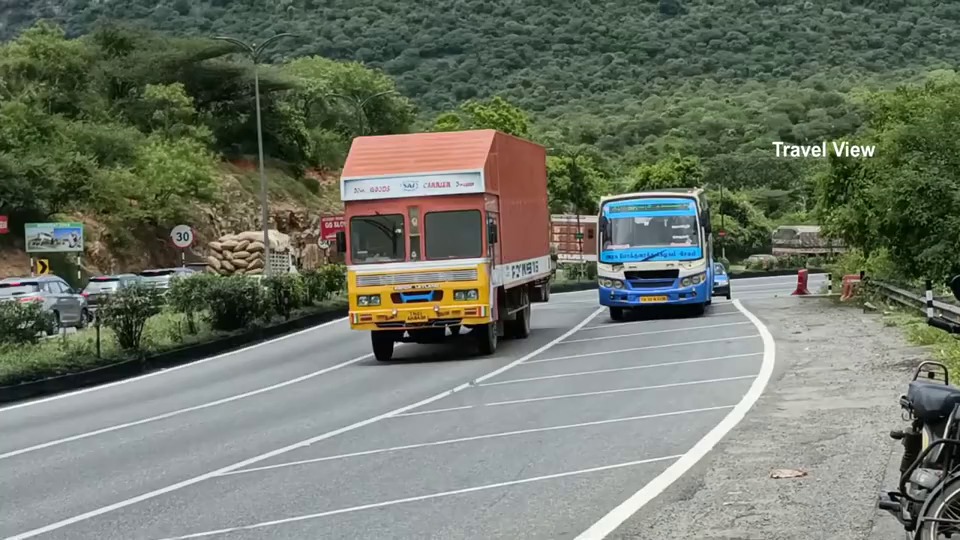

In [ ]:
from google.colab.patches import cv2_imshow
cap = cv2.VideoCapture(video_path)

while cap.isOpened():
    ret, frame = cap.read()

    if ret:
        since = time()
        ori_h, ori_w = frame.shape[:2]
        prediction = model_predict(frame, model, DEVICE)
        prediction = postprocess(prediction[0])
        prediction[:, [0, 2]] *= (ori_w/IMAGE_SIZE)
        prediction[:, [1, 3]] *= (ori_h/IMAGE_SIZE)
        prediction[:, 2].clip(max=ori_w)
        prediction[:, 3].clip(max_ori_h)

        xc = (prediction[:, 0] + prediction[:, 2]) / 2
        yc = (prediction[:, 1] + prediction[:, 3]) / 2
        w = prediction[:, 2] - prediction[:, 0]
        h = prediction[:, 3] - prediction[:, 1]
        cls_id = prediction[:, 5]
        prediction_yolo = np.stack([xc, yc, w, h, cls_id], axis=1)

        canvas = visualize(frame, prediction_yolo[:, 0:4], prediction[:, 4])
        text = f'{(time() - since) * 1000:.0f}ms/image'
        cv2.putText(canvas, text, (20, 40), cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 255), 2)
        cv2_imshow(frame)

        key = cv2.waitKey(1)
        if key == 27:
            break
        if key == ord('s'):
            cv2.waiKey()

cap.release()
cv2.destroyAllWindows()